#Import

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define file paths for features and timelines CSV files
features_path = '/content/drive/My Drive/Colab Notebooks/lab3/features.csv'
timelines_path = '/content/drive/My Drive/Colab Notebooks/lab3/timelines.csv'

# Load the features data into a Pandas DataFrame
features = pd.read_csv(features_path,sep=";")
print("Features Data (First 5 Rows):")
print(features.head())

# Load the timelines data into a Pandas DataFrame
timelines = pd.read_csv(timelines_path,sep=";")
print("\nTimelines Data (First 5 Rows):")
print(timelines.head())

Mounted at /content/drive
Features Data (First 5 Rows):
               ID  F0        F1  F2  F3  F4  F5  F6  F7
0  GIMO0741213000   0  0.260539   1   0   0   0   0   0
1  MAMA1770428016   1  0.343443   0   1   0   0   0   0
2     NHC14160717   1  0.740823   0   1   0   0   0   0
3  ARAR1670527002   1  0.459585   0   0   1   1   0   0
4        14665507   1  0.437052   0   0   1   0   0   0

Timelines Data (First 5 Rows):
               ID    tiempo1   tiempo2   tiempo3   tiempo4   tiempo5  \
0  GIMO0741213000  14.113621  1.300479  0.000000  0.000000  0.000000   
1  MAMA1770428016   8.813142  0.002738  0.884326  0.087611  0.169747   
2     NHC14160717   7.745380  0.000000  0.000000  0.000000  0.000000   
3  ARAR1670527002   7.477070  0.000000  0.000000  0.000000  0.000000   
4        14665507   6.965092  0.000000  0.000000  0.000000  0.000000   

    tiempo6   tiempo7   tiempo8   tiempo9  tiempo10  tiempo11  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.019165  0.

In [ ]:
# ==============================
# Section 1: Install Required Libraries
# ==============================
!pip install hawkeslib pandas numpy matplotlib seaborn scikit-learn scikit-learn-extra gower

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 9.1 MB/s eta 0:00:00
  Created wheel for hawkeslib: filename=hawkeslib-0.2.2-cp310-cp310-linux_x86_64.whl size=967968 sha256=0a3940bfd5d660b7c915bc9771c6f0048460f297875b8e6d1856cdd2e83b4ed4
  Stored in directory: /root/.cache/pip/wheels/10/ba/98/c762397ce381128d631933d594fb9885131aec1d63ff42fffd
Successfully built hawkeslib


In [ ]:
# ==============================
# Section 2: Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn_extra.cluster import KMedoids
import gower
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import hawkeslib as hk

#Preprocessing

Normalize the features and create absolute timeline values for the timeline dataframe.

In [ ]:
# ==============================
# Section 3: Data Preprocessing
# ==============================
warnings.filterwarnings("ignore")
# Check for missing values in features
print("Missing Values in Features:\n", features.isnull().sum())

# Print features and see what data type they have
print(features)

# Separate continuous and binary features
continuous_data = features[['F1']]
binary_data = features[['F0', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']]

# Scale continuous data, use min max scaler to bring continuous value in similar
# interval as binary categorical data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_continuous = scaler.fit_transform(continuous_data)

# Combine scaled continuous and binary data
scaled_data = pd.concat([pd.DataFrame(scaled_continuous, columns=['F1']), binary_data], axis=1)

print(scaled_data)
# Calculate absolute times in timelines for Hawkes Process
# Remove 'Cluster' column if it is still in the df i.e. if code from underneath was executed first
if 'Cluster' in timelines.columns:
    timelines.drop(columns=['Cluster'], inplace=True)

#Convert columns to numeric
for col in timelines.columns[1:]:  # Start from 'tiempo1'
    timelines[col] = pd.to_numeric(timelines[col], errors='coerce')

# Create a copy of the original DataFrame
absolute_timelines = timelines.copy()

# Iterate through columns starting from 'tiempo1'
for i in range(2, len(timelines.columns)):
    # Get the column name (e.g., 'tiempo1', 'tiempo2', etc.)
    col_name = absolute_timelines.columns[i]

    # Shift the previous column to align with current column
    prev_col_name = absolute_timelines.columns[i - 1]
    prev_col_values = absolute_timelines[prev_col_name]

    for i in range(absolute_timelines[col_name].shape[0]):
      if absolute_timelines[col_name][i] == 0:
        absolute_timelines[col_name][i] = 0
      else:
        absolute_timelines[col_name][i] = prev_col_values[i] + absolute_timelines[col_name][i]


# Print the first few rows of the new DataFrame
print("Original Timelines (Relative):")
print(timelines.head())

print("\nAbsolute Timelines:")
print(absolute_timelines.head())

Missing Values in Features:
 ID    0
F0    0
F1    0
F2    0
F3    0
F4    0
F5    0
F6    0
F7    0
dtype: int64
                  ID  F0        F1  F2  F3  F4  F5  F6  F7
0     GIMO0741213000   0  0.260539   1   0   0   0   0   0
1     MAMA1770428016   1  0.343443   0   1   0   0   0   0
2        NHC14160717   1  0.740823   0   1   0   0   0   0
3     ARAR1670527002   1  0.459585   0   0   1   1   0   0
4           14665507   1  0.437052   0   0   1   0   0   0
...              ...  ..       ...  ..  ..  ..  ..  ..  ..
1107  BETA1850704002   1  0.319240   0   0   1   0   1   1
1108        14031598   1  0.477108   0   1   0   0   0   1
1109  LUCA1741008007   1  0.432726   0   1   0   0   1   1
1110  PALO1760413000   1  0.418051   0   1   0   0   0   1
1111  BAGA1680603002   1  0.496766   0   1   0   0   0   1

[1112 rows x 9 columns]
            F1  F0  F2  F3  F4  F5  F6  F7
0     0.169406   0   1   0   0   0   0   0
1     0.277579   1   0   1   0   0   0   0
2     0.796085   1   0  

#Clustering

Find the optimal amount of clusters for the clustering.

Optimal k: 2


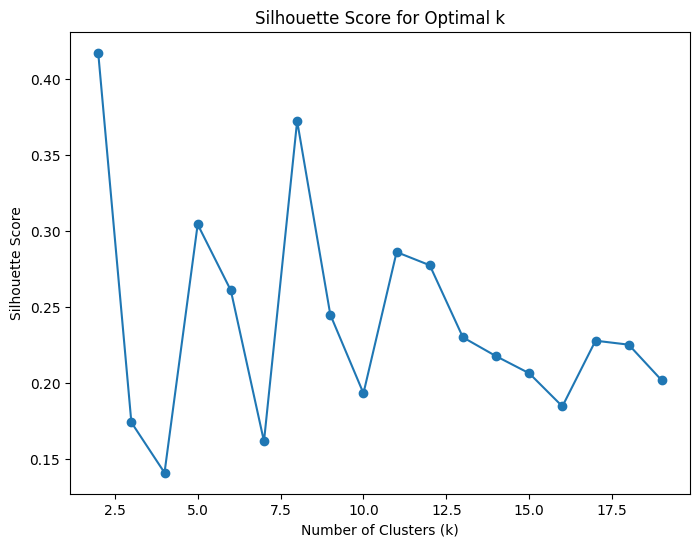

In [ ]:
# ==============================
# Section 4.1: Data Clustering
# ==============================
# Find out optimal k using the silhouette score and a gower distance matrix

# Create list of silhouette scores for different k values
silhouette_scores = []

# Calculate Gower distance matrix as distance measure for mixed data types
distance_matrix = gower.gower_matrix(scaled_data)

# Define test range
test_range = range(2, 20)

# Iterate over test range
for k in test_range:  # Range of k values
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=42)
    cluster_labels = kmedoids.fit_predict(distance_matrix)  # Use pre-computed distance matrix
    score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    silhouette_scores.append(score)

optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # Add 2 because range started from 2
print(f"Optimal k: {optimal_k}")

plt.figure(figsize=(8, 6))
plt.plot(test_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

Add Cluster labels to data

In [ ]:
# ==============================
# Section 4.2: Data Clustering
# ==============================
# Use scaled feature df to assign clusters to each datapoint
# in the absolute_timelines dataframe

# Perform K-Medoids clustering
kmedoids = KMedoids(n_clusters=optimal_k, metric='precomputed', random_state=42)
cluster_labels = kmedoids.fit_predict(distance_matrix)

# Add cluster labels to timelines and features dataframe
scaled_data['Cluster'] = cluster_labels
absolute_timelines['Cluster'] = cluster_labels
# Confirm labels have been added
print(scaled_data.head())
print(absolute_timelines.head())

# Check clustering distribution
print(scaled_data['Cluster'].value_counts())
print(absolute_timelines['Cluster'].value_counts())

         F1  F0  F2  F3  F4  F5  F6  F7  Cluster
0  0.169406   0   1   0   0   0   0   0        1
1  0.277579   1   0   1   0   0   0   0        0
2  0.796085   1   0   1   0   0   0   0        0
3  0.429123   1   0   0   1   1   0   0        1
4  0.399721   1   0   0   1   0   0   0        1
               ID    tiempo1   tiempo2   tiempo3   tiempo4   tiempo5  \
0  GIMO0741213000  14.113621  15.41410  0.000000  0.000000  0.000000   
1  MAMA1770428016   8.813142   8.81588  9.700205  9.787817  9.957563   
2     NHC14160717   7.745380   0.00000  0.000000  0.000000  0.000000   
3  ARAR1670527002   7.477070   0.00000  0.000000  0.000000  0.000000   
4        14665507   6.965092   0.00000  0.000000  0.000000  0.000000   

    tiempo6    tiempo7    tiempo8    tiempo9   tiempo10   tiempo11  Cluster  
0  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000        1  
1  9.976728  10.001369  10.806297  10.839151  10.995209  11.069132        0  
2  0.000000   0.000000   0.000000   0.0

Visualize clustering

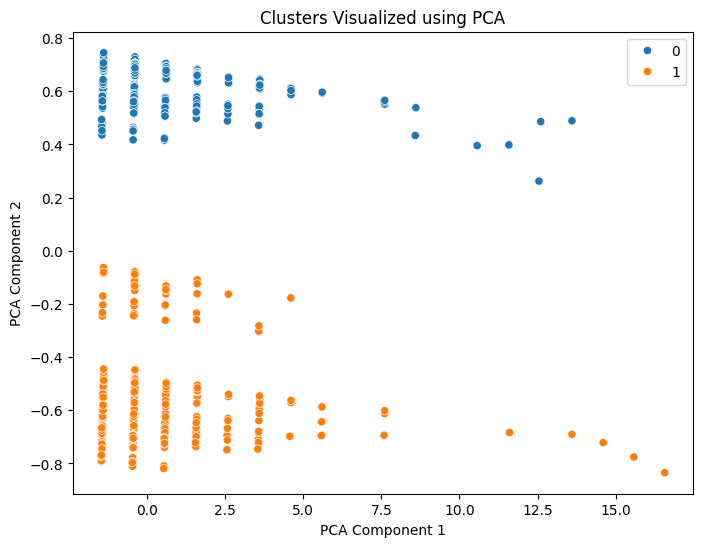

In [ ]:
# ==============================
# Section 4.3: Data Clustering
# ==============================
# Visualize the clustering using PCA

# Visualize clusters with PCA
pca = PCA(n_components=2)

# Assuming scaled_data contains the 'Cluster' column
features_for_pca = scaled_data.drop(columns=['Cluster'])

# Apply PCA to the features only
pca_result = pca.fit_transform(features_for_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],
                hue=scaled_data['Cluster'], palette="tab10")
plt.title('Clusters Visualized using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

#Hawkes Processes and Analysis

Now we separate the timelines data for each patient into the different clusters.

In [ ]:
# ==============================
# Section 5.1: Fit Hawkes Processes per Cluster
# ==============================
# Create a list of cluster dfs which contain timelines of each cluster

cluster_dfs = []  # List to store the DataFrames

for cluster_id in range(optimal_k):
    # Filter the original DataFrame based on the cluster assignment
    cluster_df = absolute_timelines[absolute_timelines['Cluster'] == cluster_id].copy()

    # Remove 'Cluster' attribute
    cluster_df.drop(columns=['Cluster'], inplace=True)

    cluster_dfs.append(cluster_df)  # Add the DataFrame to the list

# Print result
for df in cluster_dfs:
    print(df.head())

                ID   tiempo1   tiempo2   tiempo3   tiempo4   tiempo5  \
1   MAMA1770428016  8.813142  8.815880  9.700205  9.787817  9.957563   
2      NHC14160717  7.745380  0.000000  0.000000  0.000000  0.000000   
5   HEHE1930715001  6.792608  8.276523  0.000000  0.000000  0.000000   
8   SAMA1310325018  6.146475  0.000000  0.000000  0.000000  0.000000   
13        11994401  4.969199  5.070500  6.850103  0.000000  0.000000   

     tiempo6    tiempo7    tiempo8    tiempo9   tiempo10   tiempo11  
1   9.976728  10.001369  10.806297  10.839151  10.995209  11.069132  
2   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  
5   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  
8   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  
13  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  
               ID    tiempo1    tiempo2  tiempo3  tiempo4  tiempo5  tiempo6  \
0  GIMO0741213000  14.113621  15.414100      0.0      0.0      0.0  

In [ ]:
# ==============================
# Section 5.2: Fit Hawkes Processes per Cluster
# ==============================
# Initialize and fit Hawkes process for each cluster
# Additionally, calculate its intensity function at different points in time

# Set t-values to calculate the intensity of the Hawkes Process at different points in time
T_max = 20 # Set the max time
t_values = np.linspace(0, T_max, 1000)

# Set up the Hawkes Process for each cluster
# Return its parameters and its intensity function at different points in time
def createHawkesData(cluster_df, t_values):

  # In case the 'ID' attribute is still part of the df, remove it
  if 'ID' in cluster_df.columns:
    cluster_df.drop(columns='ID', inplace=True)

  # Create array that entails all the absolute timeline information in the cluster_df
  vals = []

  # Iterate over df
  for i in range(cluster_df.shape[0]):

    # Create a list of all values that are in df
    vals.append(cluster_df.iloc[i].values[cluster_df.iloc[i] > 0])

  # Concatenate the values and sort them
  all_times = np.concatenate(vals)
  all_times = np.sort(all_times) # Sort in asc order as input for fitting function

  # Determine total length of timeline data
  print(len(all_times))

  # Initialize and fit Hawkes Process
  uv = hk.UnivariateExpHawkesProcess()
  uv.fit(all_times)

  # Print hawkes parameters
  mu, alpha, beta = uv.get_params()
  print(f"Estimated Paramaters: mu =  {mu} , alpha =  {alpha},  beta =  {beta}")

  # Calculate intensity values
  intensity_values = [mu + np.sum(alpha * beta * np.exp(-beta * (x - all_times[all_times < x]))) \
          for x in t_values]

  # Additionally return all event times
  return mu, alpha, beta, all_times, intensity_values

In [ ]:
# Create a dictionary which contains all the data needed for each Hawkes Process
hawkes_parameters = {}

# Call the Hawkes Process function for every cluster
for i in range(len(cluster_dfs)):
  # Obtain the data
  mu, alpha, beta, times, intensity_values = createHawkesData(cluster_dfs[i], t_values)
  # Fill the dictionary
  hawkes_parameters[f"Cluster {i}"] = {"baseline": (mu, alpha, beta), "adjacency": times, "intensity_vals": intensity_values}

425
Estimated Paramaters: mu =  5.076651984076582 , alpha =  0.8611409822792734,  beta =  7.333323875699912
501
Estimated Paramaters: mu =  1.3797684494673526 , alpha =  0.959464234899457,  beta =  9.13687604254808


Here the intensity function for each Hawkes Process for each cluster is being plotted.

In [ ]:
# ==============================
# Section 6: Analyze Results
# ==============================
# Compare Hawkes parameters between clusters using the intensity function at different points in time
def plot_hawkes_intensity(intensity_values, cluster_id):
    """
    Plots the Hawkes intensity function for a given cluster.
    """

    # Plot the intensity function
    plt.plot(t_values, intensity_values)
    plt.title(f"Hawkes Intensity Function (Cluster {cluster_id})")
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plt.show()

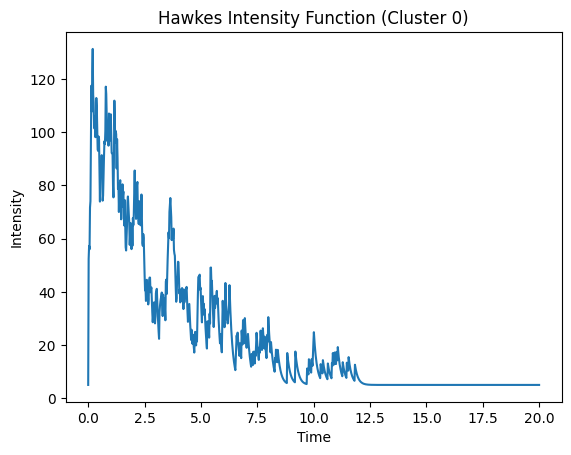

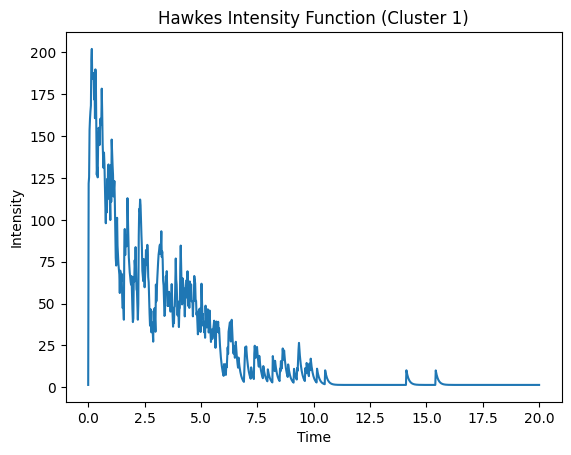

In [ ]:
# Iterate over all clusters and plot the intensity function
for cluster_id in range(len(hawkes_parameters.keys())):
    plot_hawkes_intensity(hawkes_parameters[f'Cluster {cluster_id}']['intensity_vals'], cluster_id)